In [1]:
# Create a dataloaders for the dataset
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from src.data import AminoAcidDataset
from src.model import AminoAcidCNN
from src.train import train_model, evaluate_model
from src.visual import plot_aa_distributions, plot_predicted_vs_true


In [2]:
dataset = AminoAcidDataset('data/amino_acids_augmented.pdb', padding=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=True)

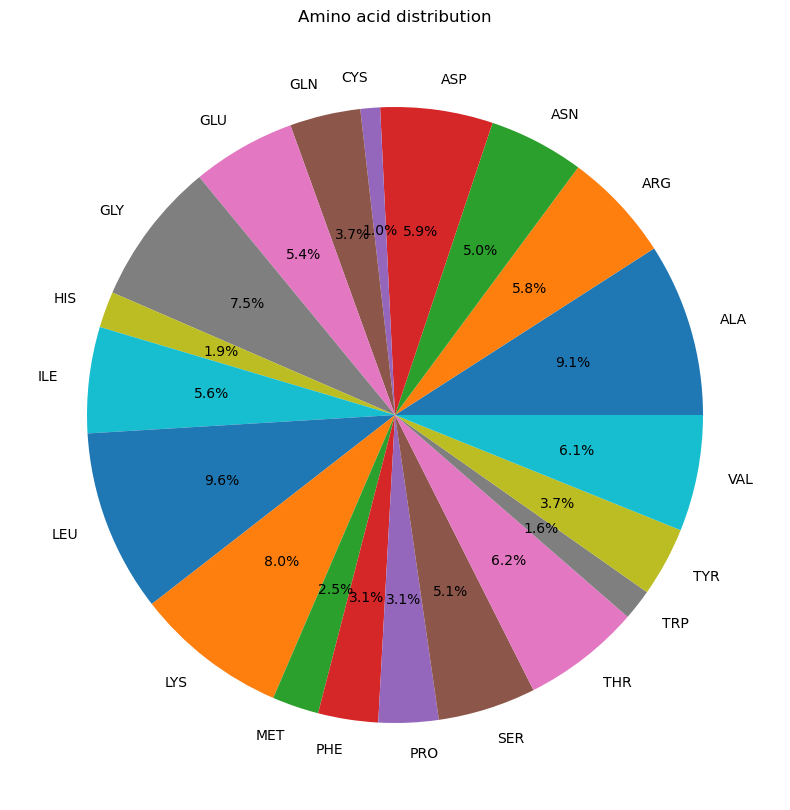

In [3]:
# plot the dataset aa distribution
plot = plot_aa_distributions(dataset)
plot["fig"]
plt.show()

In [4]:
N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types
criterium = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Let's see how the untrained model does?

{'fig': <Figure size 600x210 with 1 Axes>,
 'ax': <Axes: title={'center': 'The prediction is False,\nactual label: (THR)'}>}

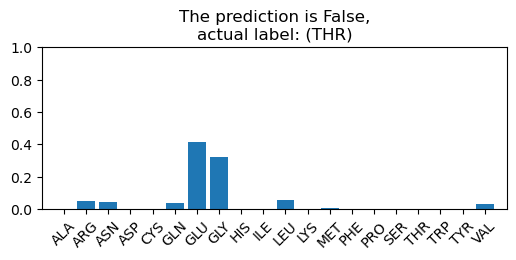

In [5]:
plot_predicted_vs_true(model, dataset[int(torch.randint(0, len(dataset), (1,)))])

In [6]:
"""
def train_model(model: torch.nn.Module, 
                data_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                n_epochs: int) -> dict:
"""

training_dict = train_model(model, train_dataloader, criterium, optimizer, 10)

In [7]:
evaluate_model(training_dict["model"], test_dataloader)

{'accuracy': 0.999593198299408}

### Next Step: Fine-Tuning the Pretrained Model

In the next step, we will continue training the pretrained model using the training dataset. This process, known as fine-tuning, allows the model to further improve its performance by learning from additional data. We will use the same loss function (`criterium`) and optimizer (`optimizer`) as before. The training will be conducted for an additional 20 epochs, and the performance of the model will be evaluated using the test dataset.

In [8]:
# now we can continue training the model
pretrained_model = training_dict["model"]
new_training_dict = train_model(pretrained_model, train_dataloader, criterium, optimizer, 20)

In [9]:
acc = evaluate_model(training_dict["model"], test_dataloader)
print(f"Accuracy: {acc}")

Accuracy: {'accuracy': 0.9997559189796448}


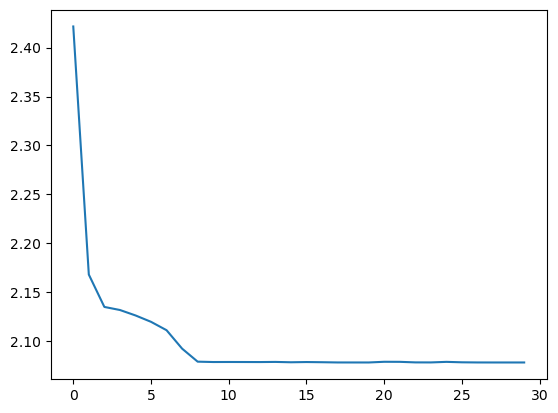

In [10]:
# plot the loss convergence
plt.plot(training_dict["total_loss"] + new_training_dict["total_loss"])
plt.show()


In [11]:
#pretrained_model = new_training_dict["model"]
#new_new_training_dict = train_model(pretrained_model, train_dataloader, criterium, optimizer, 20)

#acc = evaluate_model(training_dict["model"], test_dataloader)
#print(f"Accuracy: {acc}")

{'fig': <Figure size 600x210 with 1 Axes>,
 'ax': <Axes: title={'center': 'The prediction is True,\nactual label: (GLU)'}>}

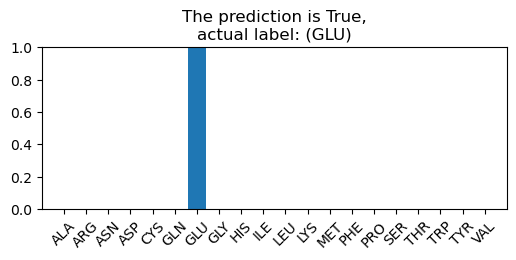

In [12]:

plot_predicted_vs_true(new_training_dict["model"], dataset[int(torch.randint(0, len(dataset), (1,)))])

In [13]:
from src.train import get_failed_predictions

failed_predictions = get_failed_predictions(new_training_dict["model"], dataset)

for i in failed_predictions:
    pass

KeyboardInterrupt: 

Actual label: LYS, predicted label: ALA
Actual label: 11, predicted label: 0


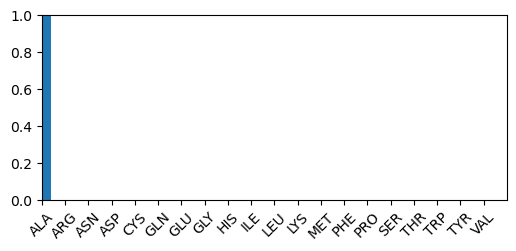



Actual label: TRP, predicted label: GLY
Actual label: 17, predicted label: 7


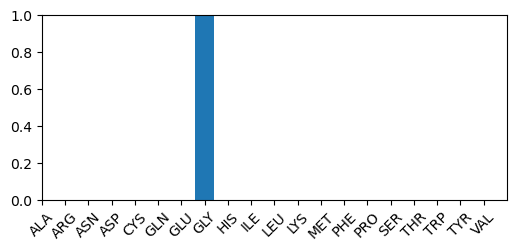



Actual label: LYS, predicted label: ALA
Actual label: 11, predicted label: 0


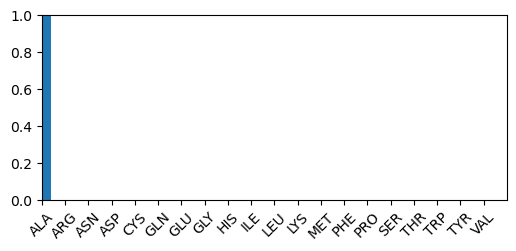



Actual label: LYS, predicted label: ALA
Actual label: 11, predicted label: 0


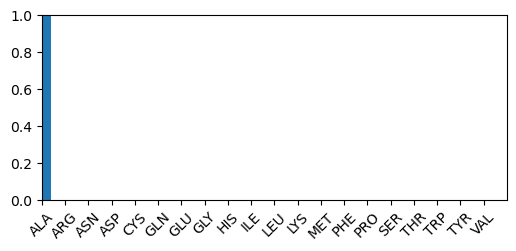



Actual label: TRP, predicted label: GLY
Actual label: 17, predicted label: 7


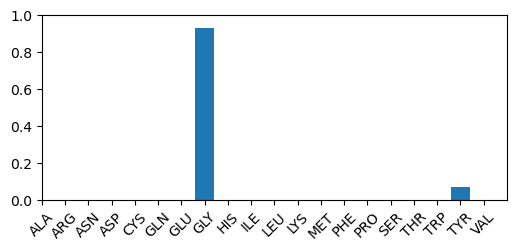



Actual label: TRP, predicted label: GLY
Actual label: 17, predicted label: 7


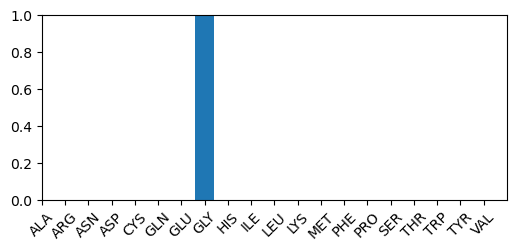



Actual label: TRP, predicted label: GLY
Actual label: 17, predicted label: 7


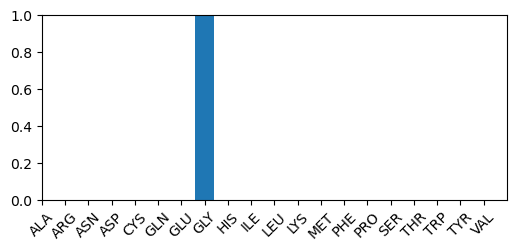



Actual label: TRP, predicted label: GLY
Actual label: 17, predicted label: 7


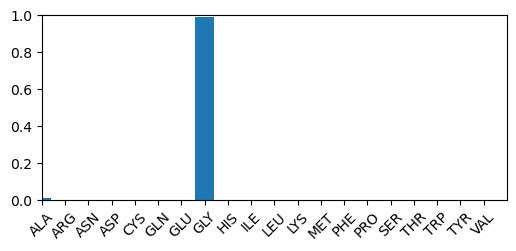

KeyboardInterrupt: 

In [14]:
# print out for all the wrong predictions what the actual label was and what the predicted label was#

amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
model = new_training_dict["model"]
resid_dict = dataset._amino_acids
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    for i in range(len(target)):
        if torch.argmax(output[i]) != target[i]:
            print(f'Actual label: {resid_dict[int(target[i])]}, predicted label: {resid_dict[int(torch.argmax(output[i]))]}')
            print(f'Actual label: {target[i]}, predicted label: {torch.argmax(output[i])}')
            # plot the output
            plt.figure(figsize=(6, 2.4))
            plt.bar(range(20),output[i].detach().numpy())
            plt.xlim(0, 20)
            plt.xticks(range(20), amino_acids, rotation=45)
            plt.ylim(0, 1)
            plt.show()
            print('')
            print('')

In [24]:
# save the model
hash = int(time.time())
rounded_accuracy = round(acc["accuracy"], 2)
model_name = 'models/{}_amino_acid_cnn_{}.pt'.format(hash, rounded_accuracy)
# Save the model
torch.save(model.state_dict(), model_name)

In [14]:
example_input ="""
CRYST1  141.584  102.814  106.186  90.00  90.00  90.00 P 1           1
ATOM      1  N   MET P   1      -5.039  22.514 -14.607  0.00  0.00      PROA  
ATOM      5  C   MET P   1      -4.754  23.169 -13.250  0.00  0.00      PROA  
ATOM      7  C   MET P   1      -4.583  24.710 -13.286  0.00  0.00      PROA   
ATOM     10  C   MET P   1      -3.182  25.121 -13.915  0.00  0.00      PROA  
ATOM     13  S   MET P   1      -1.799  24.565 -12.891  0.00  0.00      PROA  
ATOM     14  C   MET P   1      -0.460  25.268 -13.792  0.00  0.00      PROA  
ATOM     18  C   MET P   1      -5.761  22.736 -12.228  0.00  0.00      PROA  
ATOM     19  O   MET P   1      -5.383  22.214 -11.144  0.00  0.00      PROA  
ATOM     20  N   ALA P   2      -7.067  22.921 -12.541  0.00  0.00      PROA   
ATOM     22  C   ALA P   2      -8.202  22.860 -11.625  0.00  0.00      PROA  
ATOM     24  C   ALA P   2      -9.309  23.456 -12.329  0.00  0.00      PROA  
ATOM     28  C   ALA P   2      -8.499  21.436 -11.140  0.00  0.00      PROA  
ATOM     29  O   ALA P   2      -8.619  21.219  -9.960  0.00  0.00      PROA
ATOM    225  N   ALA P  15      -0.827  19.118   4.578  0.00  0.00      PROA   
ATOM    227  CA  ALA P  15       0.422  19.883   4.524  0.00  0.00      PROA  
ATOM    229  CB  ALA P  15       0.529  20.327   3.059  0.00  0.00      PROA  
ATOM    233  C   ALA P  15       0.435  21.064   5.471  0.00  0.00      PROA  
ATOM    234  O   ALA P  15       1.306  21.245   6.312  0.00  0.00      PROA  
ATOM    517  N   ALA P  33      -9.973  23.236   7.682  0.00  0.00      PROA  
ATOM    519  CA  ALA P  33     -10.415  22.007   7.097  0.00  0.00      PROA  
ATOM    521  CB  ALA P  33     -10.564  20.828   8.138  0.00  0.00      PROA  
ATOM    525  C   ALA P  33     -11.694  22.089   6.365  0.00  0.00      PROA  
ATOM    526  O   ALA P  33     -11.811  21.829   5.164  0.00  0.00      PROA  
END
"""

# we have a file with the coordinates of the atoms
# to get the sequence we start with the first one, 
# the shortest possible amino acid is 4 heavy atoms, the longest is 14
# we use the model to predict the subsets of 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 atoms
# we then select the amino acid with the highest probability that was selected by the model and take away the atoms e.g. 4 atoms
# we continue this with the next amino acid until we have no atoms left

# to avoid mistakes we exclude atom compositions that are not part of the set of amino acids:
aa_mf = {
    "ALA": "C3NO2",
    "ARG": "C6N4O2",
    "ASN": "C4N2O3",
    "ASP": "C4NO4",
    "CYS": "C3NO2S",
    "GLN": "C5N2O3",
    "GLU": "C5NO4",
    "GLY": "C2NO2",  # Corrected
    "HIS": "C6N3O2",
    "ILE": "C6NO2",
    "LEU": "C6NO2",
    "LYS": "C6N2O2",
    "MET": "C5NO2S",
    "PHE": "C9NO2",
    "PRO": "C5NO2",
    "SER": "C3NO3",
    "THR": "C4NO3",
    "TRP": "C11N2O2",
    "TYR": "C9NO3",
    "VAL": "C5NO2"
}

reference_dict = {"ALA": {"C": 3, "N": 1, "O": 1},
                  "ARG": {"C": 6, "N": 4, "O": 1},
                  "ASN": {"C": 4, "N": 2, "O": 2},
                  "ASP": {"C": 4, "N": 1, "O": 3},
                  "CYS": {"C": 3, "N": 1, "O": 1, "S": 1},
                  "GLN": {"C": 5, "N": 2, "O": 2},
                  "GLU": {"C": 5, "N": 1, "O": 3},
                  "GLY": {"C": 2, "N": 1, "O": 1},
                  "HIS": {"C": 6, "N": 3, "O": 1},
                  "ILE": {"C": 6, "N": 1, "O": 1},
                  "LEU": {"C": 6, "N": 1, "O": 1},
                  "LYS": {"C": 6, "N": 2, "O": 1},
                  "MET": {"C": 5, "N": 1, "O": 1, "S": 1},
                  "PHE": {"C": 9, "N": 1, "O": 1},
                  "PRO": {"C": 5, "N": 1, "O": 1},
                  "SER": {"C": 3, "N": 1, "O": 2},
                  "THR": {"C": 4, "N": 1, "O": 2},
                  "TRP": {"C": 11, "N": 2, "O": 1},
                  "TYR": {"C": 9, "N": 1, "O": 2},
                  "VAL": {"C": 5, "N": 1, "O": 1}
                    }


# if there is only one possible amino acid we can directly assign it
# if there are multiple possibilities we need to check the next amino 
# acid by predicting all possible subsets and picking the one with highest probability

#lets start using the example input
# we need to parse the input and get numeber of atoms and the coordinates

# we need to get the coordinates and the elements we will do this from scratch

n_atoms = 0
atoms = []
for line in example_input.split('\n'):
    if line.startswith('ATOM'):
        #print(line)
        # get the coordinates
        x = float(line[30:38])
        y = float(line[38:46])
        z = float(line[46:54])
        # get the element
        element = line[13:15].strip()
        #print(x, y, z, element)
        #print('')
        atoms.append(((x, y, z), element))
        n_atoms += 1

# now we start by subsetting the first 4-14 atoms and 

max_first = atoms[:14]
#print(max_first)

# now iterate, give the first 4, first 5, first 6, etc. atoms to the model

list_of_subset_atoms = []
for i in range(4, 15):
    subset = atoms[:i]
    # get only the elements
    elements = "".join([element for _, element in subset])
    # get a dict with the elements and their number respectively with dict comprehension
    element_dict = {element: elements.count(element) for element in set(elements)}
    list_of_subset_atoms.append(element_dict)


# for all subsets compare if they are in the reference dict
# if they are not we remove them
print(list_of_subset_atoms)
final_possible_amino_acids = []
for subset in list_of_subset_atoms:
    possible_amino_acids = []
    for amino_acid, mf in aa_mf.items():
        # check if the subset is in the reference dict regardles of the order of the elements
        # make sure that all elements are in the subset and that no additional ones are there
        try:
            if all([subset[element] == reference_dict[amino_acid][element] for element in subset]):
                # make sure no additional elements are missing in the subset
                if all([element in subset for element in reference_dict[amino_acid]]):
                    possible_amino_acids.append(amino_acid)
                    print(amino_acid, subset)
        except KeyError:
            pass
    final_possible_amino_acids.append(possible_amino_acids)
print(final_possible_amino_acids)

[{'C': 3, 'N': 1}, {'S': 1, 'C': 3, 'N': 1}, {'S': 1, 'C': 4, 'N': 1}, {'S': 1, 'C': 5, 'N': 1}, {'O': 1, 'S': 1, 'C': 5, 'N': 1}, {'O': 1, 'S': 1, 'C': 5, 'N': 2}, {'O': 1, 'S': 1, 'C': 6, 'N': 2}, {'O': 1, 'S': 1, 'C': 7, 'N': 2}, {'O': 1, 'S': 1, 'C': 8, 'N': 2}, {'O': 2, 'S': 1, 'C': 8, 'N': 2}, {'O': 2, 'S': 1, 'C': 8, 'N': 3}]
MET {'O': 1, 'S': 1, 'C': 5, 'N': 1}
[[], [], [], [], ['MET'], [], [], [], [], [], []]


### Model Performance Summary

In this notebook, we trained and evaluated a Convolutional Neural Network (CNN) model for amino acid classification. Below is a summary of the results:

- **Initial Training:**
    - **Accuracy:** The initial model achieved an accuracy of `0.92` on the test dataset.

- **Fine-Tuning:**
    - **Accuracy:** After fine-tuning the pretrained model for an additional 20 epochs, the model's accuracy on the test dataset was evaluated again and now we reach `0.99`

The fine-tuning process allowed the model to further improve its performance by learning from additional data. The final accuracy of the model after fine-tuning is reported in the subsequent cells.

In [10]:
accuracy =  Accuracy(task='MULTICLASS', num_classes=20)
model.eval()
accuracy.reset()

dataloader = test_dataloader
resid_dict = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                          7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                          14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}

for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')

# print out for all the wrong predictions what the actual label was and what the predicted label was
for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    for i in range(len(target)):
        if torch.argmax(output[i]) != target[i]:
            print(f'Actual label: {resid_dict[int(target[i])]}, predicted label: {resid_dict[int(torch.argmax(output[i]))]}')
            print(f'Actual label: {target[i]}, predicted label: {torch.argmax(output[i])}')
            print('')
            print('')

Accuracy: 0.9999186396598816
Actual label: ILE, predicted label: LEU
Actual label: 9, predicted label: 10




In [ ]:
# read rep1_frame24.pdb and extract the residues and write them to a new pdb file with END seperation for my dataset
# I will use the following code to extract the residues from the pdb file
# the new file is called demo.pdb

import os

def extract_residues(pdb_file: str, output_file: str) -> None:
    # For every time the residue changes, write END to the file, leave all Hydrogens out
    # WHEN THE ORIGINAL SAYS END, WRITE END AND STOP WRITING
    RESIDUE = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
               'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
               'THR', 'TRP', 'TYR', 'VAL']
    
    with open(pdb_file, 'r') as f:
        with open(output_file, 'w') as out:
            residue = None
            for line in f:
                if line.startswith('ATOM'):
                    current_residue = line[17:20].strip()
                    if residue is None:
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if residue != current_residue:
                        if residue in RESIDUE:
                            out.write('END\n')
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if line[12:14].strip()[0] != 'H':
                        out.write(line)
                elif line.startswith('END'):
                    if residue in RESIDUE:
                        out.write('END\n')
                    break

extract_residues('rep1_frame24.pdb', 'demo.pdb')

# from demo create a dataset demo augmented where for each residue we add 10 rotations of the residue
# I will use the following code to augment the dataset

def center_residue_to_first_atom(coordinates: torch.Tensor) -> torch.Tensor:
    # center the coordinates to the first atom
    first_atom = coordinates[0]
    centered_coordinates = coordinates - first_atom
    
    return centered_coordinates

def rotate_residue(coordinates, phi, psi, theta):
    # center the coordinates to the first atom
    centered_residue = center_residue_to_first_atom(coordinates)
    phi, psi, theta = torch.deg2rad(torch.tensor(phi)), torch.deg2rad(torch.tensor(psi)), torch.deg2rad(torch.tensor(theta))
    # rotate the molecule by phi degrees around the x-axis
    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, torch.cos(phi), -torch.sin(phi)],
                                    [0, torch.sin(phi), torch.cos(phi)]])
    rotated_residue = torch.matmul(centered_residue, rotation_matrix)
    # rotate the molecule by psi degrees around the y-axis
    rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
                                    [0, 1, 0],
                                    [-torch.sin(psi), 0, torch.cos(psi)]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)
    # rotate the molecule by theta degrees around the z-axis
    rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                    [torch.sin(theta), torch.cos(theta), 0],
                                    [0, 0, 1]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)

    return rotated_residue


def augment_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []

    for i in range(len(dataset)):
        coordinates, elements, residue = dataset[i]
        for _ in range(3):
            phi, psi, theta = torch.randint(0, 360, (1,)).item(), torch.randint(0, 360, (1,)).item(), torch.randint(0, 360, (1,)).item()
            # center the coordinates to the first atom
            rotated_coordinates = rotate_residue(coordinates, phi, psi, theta)
            for j in range(len(rotated_coordinates)):
                # pdb format is ATOM  1    C ALA A   1     1.000   2.000   3.000  1.00  0.00
                augmented_lines.append(f'ATOM {j + 1:6d} {element_to_name[int(torch.argmax(elements[j]))]:>2}   {residue_to_name[int(torch.argmax(residue))]:>3}     1    {rotated_coordinates[j][0]:8.3f}{rotated_coordinates[j][1]:8.3f}{rotated_coordinates[j][2]:8.3f}    1.00  0.00\n')
            augmented_lines.append('END\n')
    with open(output_file, 'w') as f:
        f.writelines(augmented_lines)


dataset = AminoAcidDataset('data/amino_acids.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_augmented.pdb')






In [3]:
from src.data_prep import augment_dataset
from src.data import AminoAcidDataset
from torch.utils.data import DataLoader


dataset = AminoAcidDataset('data/amino_acids.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_augmented.pdb',5)

In [5]:
augment_dataset(dataset, 'data/amino_acids_augmented.pdb',3)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.6550,  1.3570],
        [ 0.4560,  2.1960,  1.3210],
        [ 1.8570,  2.6070,  0.6920],
        [ 3.2400,  2.0510,  1.7160],
        [ 4.5790,  2.7540,  0.8150],
        [-0.7220,  0.2220,  2.3790],
        [-0.3440, -0.3000,  3.4630]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.6550,  1.3570],
        [ 0.4560,  2.1960,  1.3210],
        [ 1.8570,  2.6070,  0.6920],
        [ 3.2400,  2.0510,  1.7160],
        [ 4.5790,  2.7540,  0.8150],
        [-0.7220,  0.2220,  2.3790],
        [-0.3440, -0.3000,  3.4630]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2850,  0.8807,  1.2226],
        [ 0.4560,  2.3920,  0.9196],
        [ 1.8570,  2.6876,  0.2288],
        [ 3.2400,  2.3178,  1.3338],
        [ 4.5790,  2.8537,  0.3244],
        [-0.7220,  0.6317,  2.3043],
        [-0.3440,  0.3059,  3.4625]])


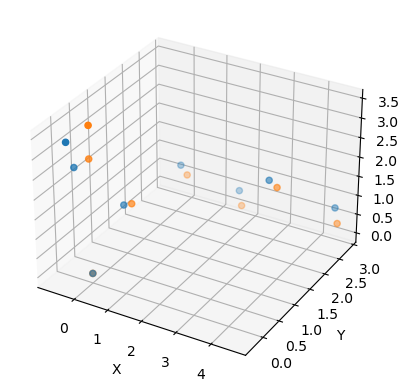

In [ ]:
# rotate this molecule:
residue = torch.tensor([[ -5.0390,  22.5140, -14.6070],
                        [ -4.7540,  23.1690, -13.2500],
                        [ -4.5830,  24.7100, -13.2860],
                        [ -3.1820,  25.1210, -13.9150],
                        [ -1.7990,  24.5650, -12.8910],
                        [ -0.4600,  25.2680, -13.7920],
                        [ -5.7610,  22.7360, -12.2280],
                        [ -5.3830,  22.2140, -11.1440]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_residue(coordinates):

    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # we want to plot lines between the atoms if the distance is under a certain threshold

    for i in range(len(coordinates)):
        for j in range(i+1, len(coordinates)):
            distance = torch.norm(coordinates[i] - coordinates[j])
            if distance < 2:
                ax.plot([coordinates[i][0], coordinates[j][0]], [coordinates[i][1], coordinates[j][1]], [coordinates[i][2], coordinates[j][2]])



# center the coordinates to the first atom
centered_residue = center_residue_to_first_atom(residue)
print(centered_residue)

plot_residue(centered_residue)
# rotate the molecule by 90 degrees around the z-axis
theta = 10
theta = torch.deg2rad(torch.tensor(theta))
rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                [torch.sin(theta), torch.cos(theta), 0],
                                [0, 0, 1]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)

# rotate the molecule by 90 degrees around the x-axis
#phi = 30
#phi = torch.deg2rad(torch.tensor(phi))
#rotation_matrix = torch.tensor([[1, 0, 0],
#                                [0, torch.cos(phi), -torch.sin(phi)],
#                                [0, torch.sin(phi), torch.cos(phi)]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)


# rotate the molecule by 90 degrees around the y-axis
#psi = 45
#psi = torch.deg2rad(torch.tensor(psi))
#
#rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
#                                [0, 1, 0],
#                                [-torch.sin(psi), 0, torch.cos(psi)]])
#rotated_residue = torch.matmul(centered_residue, rotation_matrix)
#print("Rotated Residue:\n", rotated_residue)
#plot_residue(rotated_residue)

def rotate_residue(coordinates, phi, psi, theta):
    # center the coordinates to the first atom
    centered_residue = center_residue_to_first_atom(coordinates)
    phi, psi, theta = torch.deg2rad(torch.tensor(phi)), torch.deg2rad(torch.tensor(psi)), torch.deg2rad(torch.tensor(theta))
    print(centered_residue)
    # rotate the molecule by phi degrees around the x-axis
    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, torch.cos(phi), -torch.sin(phi)],
                                    [0, torch.sin(phi), torch.cos(phi)]])
    rotated_residue = torch.matmul(centered_residue, rotation_matrix)
    # rotate the molecule by psi degrees around the y-axis
    rotation_matrix = torch.tensor([[torch.cos(psi), 0, torch.sin(psi)],
                                    [0, 1, 0],
                                    [-torch.sin(psi), 0, torch.cos(psi)]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)
    # rotate the molecule by theta degrees around the z-axis
    rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                                    [torch.sin(theta), torch.cos(theta), 0],
                                    [0, 0, 1]])
    rotated_residue = torch.matmul(rotated_residue, rotation_matrix)

    return rotated_residue

final = rotate_residue(residue, 10,0,0)
print(final)
plot_residue(final)

In [67]:
dataset = AminoAcidDataset('demo_augmented.pdb')
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

In [ ]:
# read rep1_frame24.pdb and extract the residues and write them to a new pdb file with END seperation for my dataset
# I will use the following code to extract the residues from the pdb file
# the new file is called demo.pdb

import os

def extract_residues(pdb_file: str, output_file: str) -> None:
    # For every time the residue changes, write END to the file, leave all Hydrogens out
    # WHEN THE ORIGINAL SAYS END, WRITE END AND STOP WRITING
    RESIDUE = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
               'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
               'THR', 'TRP', 'TYR', 'VAL']
    
    with open(pdb_file, 'r') as f:
        with open(output_file, 'w') as out:
            residue = None
            for line in f:
                if line.startswith('ATOM'):
                    current_residue = line[17:20].strip()
                    if residue is None:
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if residue != current_residue:
                        if residue in RESIDUE:
                            out.write('END\n')
                        residue = current_residue
                        if residue not in RESIDUE:
                            residue = None
                            continue
                    if line[12:14].strip()[0] != 'H':
                        out.write(line)
                elif line.startswith('END'):
                    if residue in RESIDUE:
                        out.write('END\n')
                    break

extract_residues('rep1_frame24.pdb', 'demo.pdb')

# from demo create a dataset demo augmented where for each residue we add 10 rotations of the residue
# I will use the following code to augment the dataset

def center_residue_to_first_atom(coordinates: torch.Tensor) -> torch.Tensor:
    # center the coordinates to the first atom
    first_atom = coordinates[0]
    centered_coordinates = coordinates - first_atom
    return centered_coordinates



def augment_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []

    for i in range(len(dataset)):
        coordinates, elements, residue = dataset[i]
        print(coordinates)
        break
     
        for _ in range(1):
            # center the coordinates to the first atom
            rotated_coordinates = center_residue_to_first_atom(coordinates)
            for j in range(len(rotated_coordinates)):
                # pdb format is ATOM  1    C ALA A   1     1.000   2.000   3.000  1.00  0.00
                augmented_lines.append(f'ATOM {j + 1:6d} {element_to_name[int(torch.argmax(elements[j]))]:>2}   {residue_to_name[int(torch.argmax(residue))]:>3}     1    {rotated_coordinates[j][0]:8.3f}{rotated_coordinates[j][1]:8.3f}{rotated_coordinates[j][2]:8.3f}    1.00  0.00\n')
            augmented_lines.append('END\n')
    with open(output_file, 'w') as f:
        f.writelines(augmented_lines)


dataset = AminoAcidDataset('demo.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'demo_augmented.pdb')




def rotated_dataset(dataset: AminoAcidDataset, output_file: str) -> None:
    residue_to_name = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                       'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
    element_to_name = ['C', 'N', 'O', 'S']

    augmented_lines = []


tensor([[ -5.0390,  22.5140, -14.6070],
        [ -4.7540,  23.1690, -13.2500],
        [ -4.5830,  24.7100, -13.2860],
        [ -3.1820,  25.1210, -13.9150],
        [ -1.7990,  24.5650, -12.8910],
        [ -0.4600,  25.2680, -13.7920],
        [ -5.7610,  22.7360, -12.2280],
        [ -5.3830,  22.2140, -11.1440]])


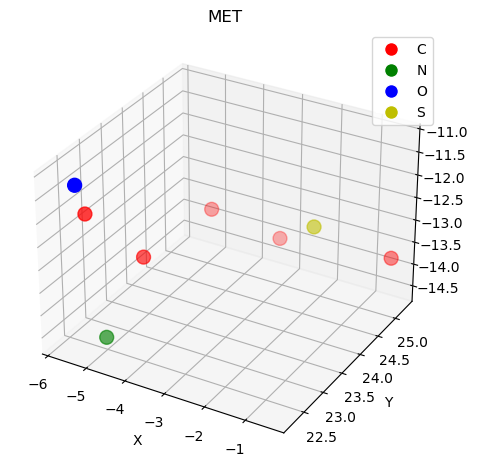

In [8]:
# plot an example of the data residue 

coordinates, elements, residue = dataset[0]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

element_colors = { 0: 'r', 1: 'g', 2: 'b', 3: 'y' }
# coordinates and colored by the element type with a legend
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=[element_colors[int(torch.argmax(e))] for e in elements], s=100)
# fix a legend with the right colors for the elements
ax.set_xlabel('X')
ax.set_ylabel('Y')


residue_dict = {1:"ALA", 2:"ARG", 3:"ASN", 4:"ASP", 5:"CYS", 6:"GLN", 7:"GLU",
                8:"GLY", 9:"HIS", 10:"ILE", 11:"LEU", 12:"LYS", 13:"MET", 14:"PHE", 
                15:"PRO", 16:"SER", 17:"THR", 18:"TRP", 19:"TYR", 20:"VAL"}
plt.title(residue_dict[int(torch.argmax(residue))+1])
element_dict = {0:"C", 1:"N", 2:"O", 3:"S"}

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='C'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='N'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='O'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='y', markersize=10, label='S')])
plt.tight_layout()
plt.show()
